In [1]:
import os
import sys
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.applications.densenet import DenseNet121, preprocess_input
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt
from collections import Counter
import util  # Assuming this is a custom module

2024-12-12 01:10:28.978935: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-12 01:10:28.992843: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1733965829.007650   14538 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1733965829.012109   14538 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-12 01:10:29.028725: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [2]:
# Paths to the dataset
train_dir = "../dataset/split_tiga/train"
val_dir = "../dataset/split_tiga/val"
test_dir = "../dataset/split_tiga/test"
IMAGE_DIR = "../dataset/split_tiga/test"

In [3]:
def count_labels(directory):
    """Count the labels in the dataset directory."""
    label_counts = Counter()
    for class_dir in os.listdir(directory):
        class_path = os.path.join(directory, class_dir)
        if os.path.isdir(class_path):
            label_counts[class_dir] = len(os.listdir(class_path))  # Simplified counting
    return label_counts

In [4]:
# Count labels for train, val, and test sets
train_counts = count_labels(train_dir)
val_counts = count_labels(val_dir)
test_counts = count_labels(test_dir)

In [5]:
# Calculate class weights
train_total = sum(train_counts.values())
class_weights = {label: train_total / (len(train_counts) * count) 
                 for label, count in train_counts.items()}

In [6]:
print("Train label counts:", train_counts)
print("Validation label counts:", val_counts)
print("Test label counts:", test_counts)
print("Class weights:", class_weights)

Train label counts: Counter({'nv': 4693, 'mel': 779, 'bkl': 769, 'bcc': 359, 'akiec': 228, 'vasc': 99, 'df': 80})
Validation label counts: Counter({'nv': 1006, 'mel': 167, 'bkl': 165, 'bcc': 77, 'akiec': 49, 'vasc': 21, 'df': 17})
Test label counts: Counter({'nv': 1007, 'mel': 167, 'bkl': 166, 'bcc': 78, 'akiec': 50, 'vasc': 22, 'df': 18})
Class weights: {'bkl': 1.3016905071521456, 'nv': 0.21329639889196675, 'df': 12.5125, 'mel': 1.2849807445442876, 'vasc': 10.11111111111111, 'bcc': 2.788300835654596, 'akiec': 4.390350877192983}


In [7]:
# TensorFlow weighted loss function
def weighted_loss(pos_weights, neg_weights):
    """Create a weighted loss function."""
    def loss_fn(y_true, y_pred):
        pos_loss = -pos_weights * y_true * tf.math.log(y_pred + tf.keras.backend.epsilon())
        neg_loss = -neg_weights * (1 - y_true) * tf.math.log(1 - y_pred + tf.keras.backend.epsilon())
        return tf.reduce_mean(pos_loss + neg_loss)
    return loss_fn

In [8]:
# --- Model Definition and Compilation ---
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3)) 
x = base_model.output
x = GlobalAveragePooling2D()(x)
labels = list(train_counts.keys())

I0000 00:00:1733965838.312966   14538 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 43629 MB memory:  -> device: 0, name: NVIDIA L40S, pci bus id: 0000:64:00.0, compute capability: 8.9


In [9]:
# If you have pre-calculated weights, use them here
pos_weights = np.array([class_weights[label] for label in labels]) 
neg_weights = np.ones(len(labels)) 

predictions = Dense(len(labels), activation="sigmoid")(x)
model = Model(inputs=base_model.input, outputs=predictions)

In [10]:
# Compile the model
model.compile(optimizer='adam', loss=weighted_loss(pos_weights, neg_weights), metrics=['accuracy']) 

In [12]:
# --- Data Generators ---
train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    # Add more augmentations here if needed (rotation, shear, zoom, etc.)
)
val_datagen = ImageDataGenerator(rescale=1.0/255.0)
test_datagen = ImageDataGenerator(rescale=1.0/255.0)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,  # Adjust batch size if needed
    class_mode='categorical'
)

valid_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32, 
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32, 
    class_mode='categorical',
    shuffle=False  # Important for evaluation
)

Found 7007 images belonging to 7 classes.
Found 1502 images belonging to 7 classes.
Found 1510 images belonging to 7 classes.


In [13]:
# --- Model Training ---
history = model.fit(
    train_generator,
    validation_data=valid_generator,
    steps_per_epoch=len(train_generator),  # Use the entire training set in each epoch
    validation_steps=len(valid_generator), # Use the entire validation set
    epochs=10,  # Adjust the number of epochs as needed
)

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10


I0000 00:00:1733965891.457831   14938 service.cc:148] XLA service 0x7fb600002430 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1733965891.457866   14938 service.cc:156]   StreamExecutor device (0): NVIDIA L40S, Compute Capability 8.9
2024-12-12 01:11:32.592943: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1733965896.837782   14938 cuda_dnn.cc:529] Loaded cuDNN version 90501
2024-12-12 01:11:39.109686: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_30783', 4 bytes spill stores, 4 bytes spill loads

2024-12-12 01:11:39.251839: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_30783', 196 bytes spill stor

  2/219 ━━━━━━━━━━━━━━━━━━━━ 12s 56ms/step - accuracy: 0.0859 - loss: 1.3468   

I0000 00:00:1733965946.004690   14938 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


 46/219 ━━━━━━━━━━━━━━━━━━━━ 22s 131ms/step - accuracy: 0.4827 - loss: 0.7942

2024-12-12 01:12:38.699678: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_30783', 324 bytes spill stores, 324 bytes spill loads

2024-12-12 01:12:38.757471: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_30783', 428 bytes spill stores, 428 bytes spill loads



219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 380ms/step - accuracy: 0.5976 - loss: 0.5799

2024-12-12 01:14:03.017473: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_3311', 324 bytes spill stores, 324 bytes spill loads

2024-12-12 01:14:03.074597: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_3311', 420 bytes spill stores, 420 bytes spill loads



219/219 ━━━━━━━━━━━━━━━━━━━━ 189s 468ms/step - accuracy: 0.5979 - loss: 0.5794 - val_accuracy: 0.6478 - val_loss: 0.5456
Epoch 2/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 35s 159ms/step - accuracy: 0.7036 - loss: 0.4003 - val_accuracy: 0.3289 - val_loss: 3.0749
Epoch 3/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 35s 159ms/step - accuracy: 0.7052 - loss: 0.3794 - val_accuracy: 0.5619 - val_loss: 0.6666
Epoch 4/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 34s 156ms/step - accuracy: 0.7347 - loss: 0.3738 - val_accuracy: 0.6511 - val_loss: 0.5585
Epoch 5/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 35s 160ms/step - accuracy: 0.7349 - loss: 0.3409 - val_accuracy: 0.5626 - val_loss: 0.5728
Epoch 6/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 35s 159ms/step - accuracy: 0.7506 - loss: 0.3293 - val_accuracy: 0.7170 - val_loss: 0.4159
Epoch 7/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 35s 158ms/step - accuracy: 0.7554 - loss: 0.3225 - val_accuracy: 0.7004 - val_loss: 0.4256
Epoch 8/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 35s 160ms/step - accuracy: 0.7714 - loss: 0.3049 - va

In [14]:
# --- TFLite Conversion ---
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open('final_model.tflite', 'wb') as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmpg85ttk2g/assets


INFO:tensorflow:Assets written to: /tmp/tmpg85ttk2g/assets


Saved artifact at '/tmp/tmpg85ttk2g'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 7), dtype=tf.float32, name=None)
Captures:
  140441866812784: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140441866812080: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140441866808912: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140441866810320: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140441866811200: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140441862674336: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140441862672752: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140441862673280: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140441862674864: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140441862682080: TensorSpec(shape=(), dtype=tf.resource, name=None)
  14044186268102

W0000 00:00:1733966387.289565   14538 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1733966387.289602   14538 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
2024-12-12 01:19:47.290161: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpg85ttk2g
2024-12-12 01:19:47.304756: I tensorflow/cc/saved_model/reader.cc:52] Reading meta graph with tags { serve }
2024-12-12 01:19:47.304778: I tensorflow/cc/saved_model/reader.cc:147] Reading SavedModel debug info (if present) from: /tmp/tmpg85ttk2g
I0000 00:00:1733966387.511930   14538 mlir_graph_optimization_pass.cc:401] MLIR V1 optimization pass is not enabled
2024-12-12 01:19:47.552429: I tensorflow/cc/saved_model/loader.cc:236] Restoring SavedModel bundle.
2024-12-12 01:19:48.967758: I tensorflow/cc/saved_model/loader.cc:220] Running initialization op on SavedModel bundle at path: /tmp/tmpg85ttk2g
2024-12-12 01:19:49.305702: I tensorflow/cc/saved_model/loader.cc:466] SavedModel 

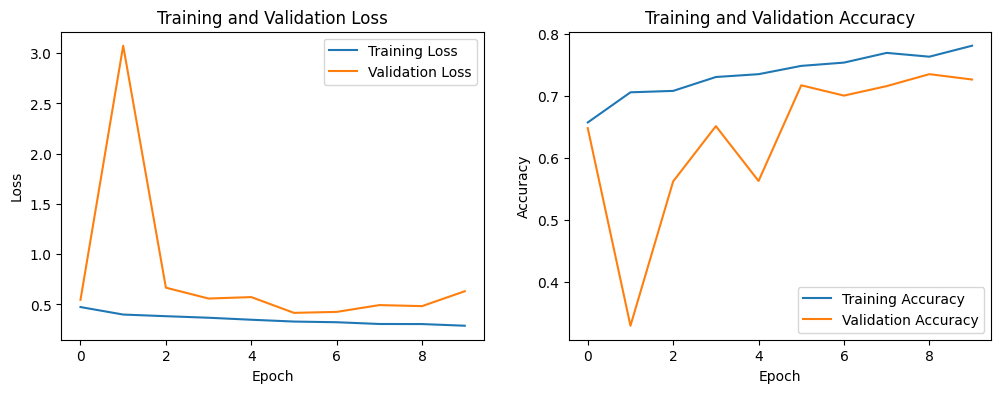

In [15]:
# --- Evaluation ---
# Plot the training loss and accuracy curves
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Training and Validation Loss")

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Training and Validation Accuracy")
plt.show()

In [16]:
# Predict using the model
predicted_vals = model.predict(test_generator, steps=len(test_generator))
print("Predictions completed.")

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


47/48 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step

2024-12-12 01:20:31.005646: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_3273', 40 bytes spill stores, 40 bytes spill loads



48/48 ━━━━━━━━━━━━━━━━━━━━ 20s 283ms/step
Predictions completed.


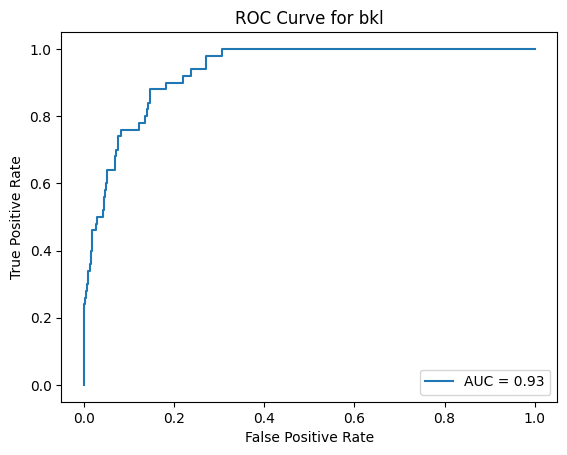

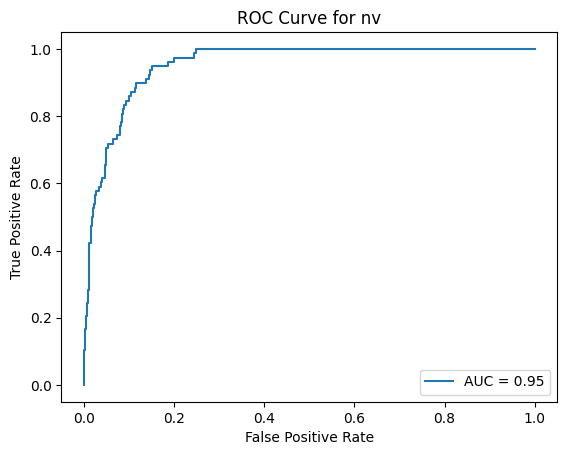

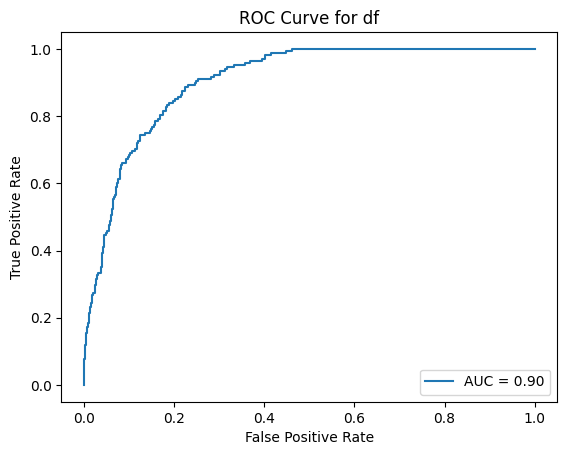

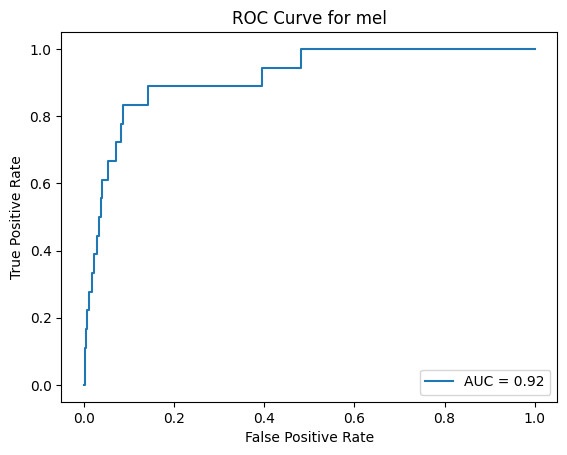

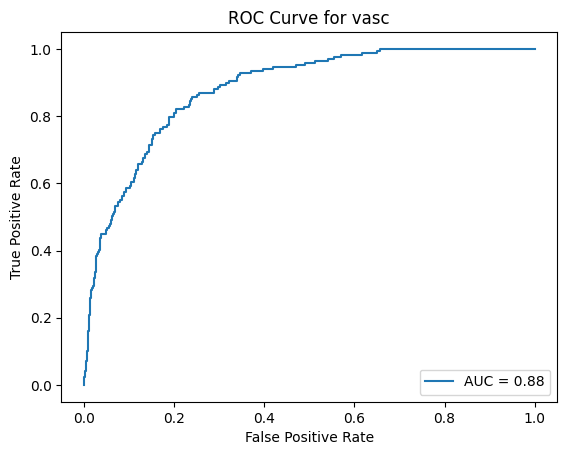

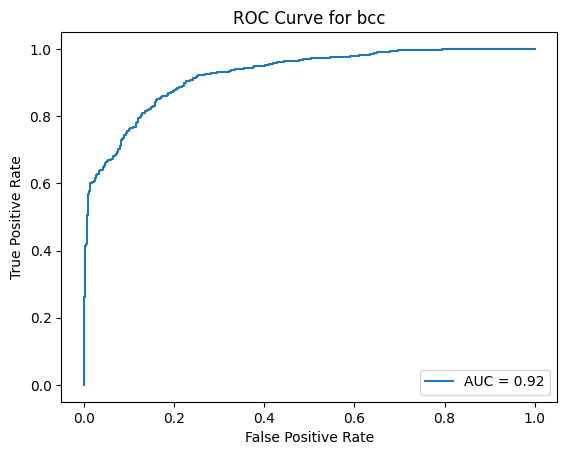

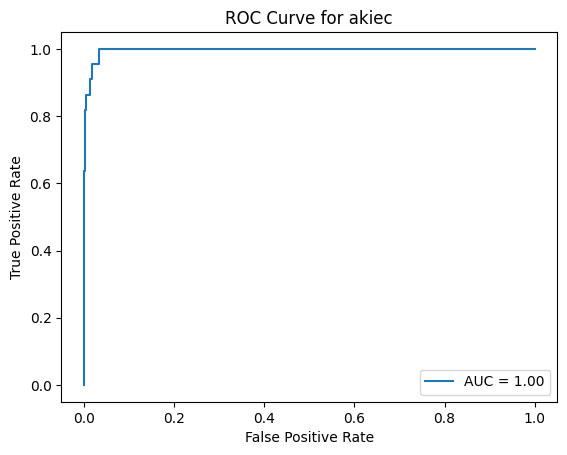

AUC-ROC scores: {'bkl': np.float64(0.9341095890410959), 'nv': np.float64(0.9532839134794442), 'df': np.float64(0.9042296501312895), 'mel': np.float64(0.9151772415847483), 'vasc': np.float64(0.8805962163535921), 'bcc': np.float64(0.9239024640636816), 'akiec': np.float64(0.9961815738025415)}


In [17]:
# --- ROC Curve ---
def get_roc_curve(labels, predicted_vals, generator):
    """Compute ROC curve and AUC for each label."""
    auc_roc_scores = {}
    true_labels = generator.labels
    if len(true_labels.shape) == 1:
        from tensorflow.keras.utils import to_categorical
        true_labels = to_categorical(true_labels, num_classes=len(labels))

    for idx, label in enumerate(labels):
        true_vals = true_labels[:, idx]
        preds = predicted_vals[:, idx]
        auc = roc_auc_score(true_vals, preds)
        auc_roc_scores[label] = auc
        fpr, tpr, _ = roc_curve(true_vals, preds)
        plt.figure()
        plt.plot(fpr, tpr, label=f'AUC = {auc:.2f}')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'ROC Curve for {label}')
        plt.legend(loc='lower right')
        plt.show()
    return auc_roc_scores

auc_rocs = get_roc_curve(labels, predicted_vals, test_generator)
print("AUC-ROC scores:", auc_rocs)